<a href="https://colab.research.google.com/github/harshitasakhare/Python-/blob/main/Taxi_Fare_Problem_streamlit%20app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# 🚖 Taxi Fare Prediction using Python and Machine Learning
# Dataset Source: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction

# ========================
# 1. Import Required Libraries
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
!pip install haversine
!pip install streamlit
import streamlit
import haversine
import warnings
warnings.filterwarnings('ignore')


In [28]:
# ========================
# 2. Load and Explore the Dataset
# ========================
# Load a sample of the dataset for faster execution
df = pd.read_csv('/content/drive/MyDrive/dataset/sample_taxi_fare_data.csv', nrows=500000)
df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2019-01-11 23:15:00,-73.988119,40.782267,-73.831987,40.711348,4,59.05
1,2019-01-01 14:20:00,-73.723045,40.673306,-73.912668,40.860929,5,99.69
2,2019-02-23 08:20:00,-73.750665,40.749474,-73.790579,40.819149,1,30.09
3,2019-02-08 02:46:00,-74.035294,40.699105,-74.050640,40.794314,3,30.16
4,2019-01-05 08:25:00,-73.785490,40.880108,-73.849471,40.838872,1,26.69


In [29]:
# ========================
# 3. Data Cleaning
# ========================
# Drop rows with nulls
df.dropna(inplace=True)

# Remove invalid fare amounts
df = df[df['fare_amount'] > 0]

# Reasonable coordinate ranges (New York City bounds)
df = df[(df['pickup_latitude'].between(40, 42)) & (df['pickup_longitude'].between(-75, -72))]
df = df[(df['dropoff_latitude'].between(40, 42)) & (df['dropoff_longitude'].between(-75, -72))]

# Reasonable passenger count
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

df.shape


(1000, 7)

In [30]:
# ========================
# 4. Feature Engineering
# ========================

# Convert datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True)

# Extract datetime features
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month

# Distance calculation using Haversine
def calculate_distance(row):
    p1 = (row['pickup_latitude'], row['pickup_longitude'])
    p2 = (row['dropoff_latitude'], row['dropoff_longitude'])
    return haversine.haversine(p1, p2) # Use haversine.haversine()

df['distance_km'] = df.apply(calculate_distance, axis=1)

# Drop original datetime column
df.drop(['pickup_datetime'], axis=1, inplace=True)

df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,hour,day_of_week,month,distance_km
0,-73.988119,40.782267,-73.831987,40.711348,4,59.05,23,4,1,15.335582
1,-73.723045,40.673306,-73.912668,40.860929,5,99.69,14,1,1,26.272992
2,-73.750665,40.749474,-73.790579,40.819149,1,30.09,8,5,2,8.444891
3,-74.035294,40.699105,-74.050640,40.794314,3,30.16,2,4,2,10.665450
4,-73.785490,40.880108,-73.849471,40.838872,1,26.69,8,5,1,7.069390


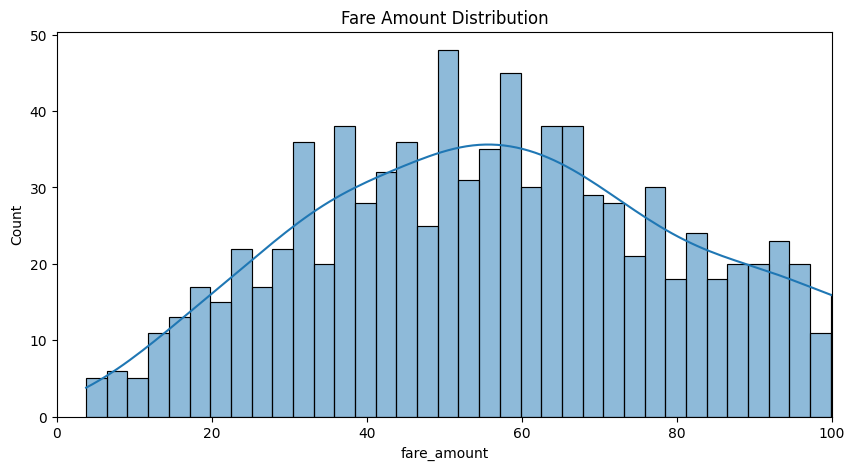

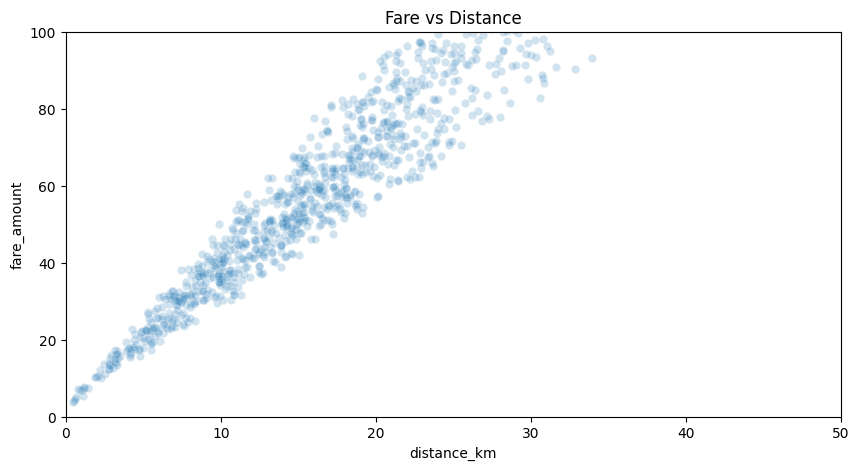

In [31]:
# ========================
# 5. Exploratory Data Analysis (EDA)
# ========================
plt.figure(figsize=(10,5))
sns.histplot(df['fare_amount'], bins=60, kde=True)
plt.title("Fare Amount Distribution")
plt.xlim(0, 100)
plt.show()

plt.figure(figsize=(10,5))
sns.scatterplot(x='distance_km', y='fare_amount', data=df, alpha=0.2)
plt.title("Fare vs Distance")
plt.xlim(0, 50)
plt.ylim(0, 100)
plt.show()

In [32]:
# ========================
# 6. Prepare Data for Modeling
# ========================
features = ['passenger_count', 'hour', 'day_of_week', 'month', 'distance_km']
X = df[features]
y = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
# ========================
# 7. Train Random Forest Regressor
# ========================
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Random Forest RMSE: ${rmse:.2f}")


Random Forest RMSE: $9.38


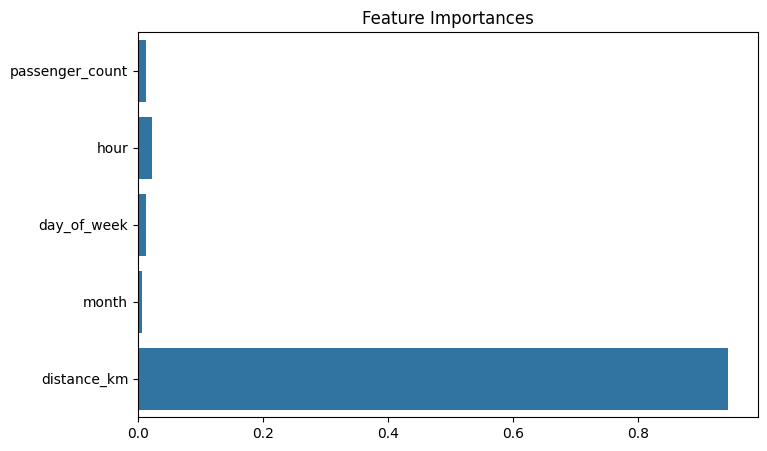

In [34]:
# ========================
# 8. Feature Importance
# ========================
importances = rf.feature_importances_
plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.show()


In [35]:
# Modeling
target = 'fare_amount'
features = ['passenger_count', 'hour', 'day_of_week', 'month', 'distance_km']
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
print(f"Gradient Boosting RMSE: ${rmse_gbr:.2f}")

Gradient Boosting RMSE: $9.34


In [37]:
# XGBoost
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost RMSE: ${rmse_xgb:.2f}")

XGBoost RMSE: $10.29


In [38]:
# Streamlit App
import streamlit as st

st.title("🚖 Taxi Fare Prediction App")

st.sidebar.header("Input Ride Details")
distance = st.sidebar.slider("Distance (km)", 0.1, 50.0, 5.0)
hour = st.sidebar.slider("Pickup Hour", 0, 23, 14)
day = st.sidebar.slider("Day of Week (0=Mon)", 0, 6, 2)
month = st.sidebar.slider("Month", 1, 12, 5)
passenger = st.sidebar.slider("Passenger Count", 1, 6, 1)

input_df = pd.DataFrame([[passenger, hour, day, month, distance]], columns=features)
predicted_fare = xgb_model.predict(input_df)[0]

st.subheader("Predicted Fare")
st.write(f"💰 ${predicted_fare:.2f}")

2025-06-27 17:43:18.074 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-27 17:43:18.076 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-27 17:43:18.077 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-27 17:43:18.078 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-27 17:43:18.081 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-27 17:43:18.082 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-27 17:43:18.085 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-27 17:43:18.086 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [39]:
# Streamlit App
import streamlit as st
import pandas as pd
import joblib

# Load the XGBoost model
model = joblib.load("xgb_model.pkl")

st.title("🚖 NYC Taxi Fare Predictor")

st.sidebar.header("Input Ride Details")
distance = st.sidebar.slider("Distance (km)", 0.1, 50.0, 5.0)
hour = st.sidebar.slider("Pickup Hour", 0, 23, 14)
day = st.sidebar.slider("Day of Week (0=Mon)", 0, 6, 2)
month = st.sidebar.slider("Month", 1, 12, 5)
passenger = st.sidebar.slider("Passenger Count", 1, 6, 1)

input_df = pd.DataFrame([[passenger, hour, day, month, distance]], columns=['passenger_count', 'hour', 'day_of_week', 'month', 'distance_km'])
predicted_fare = model.predict(input_df)[0]

st.subheader("Predicted Fare")
st.write(f"💰 ${predicted_fare:.2f}")

2025-06-27 17:43:18.187 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-27 17:43:18.192 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-27 17:43:18.193 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-27 17:43:18.194 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-27 17:43:18.195 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-27 17:43:18.195 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-27 17:43:18.196 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-27 17:43:18.198 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [25]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.150.186.53:8501

  Stopping...
  Stopping...
Exception ignored in: <module 'threading' from '/usr/lib/python3.11/threading.py'>
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1541, in _shutdown
    def _shutdown():
    
  File "/usr/local/lib/python3.11/dist-packages/streamlit/web/bootstrap.py", line 43, in signal_handler
    server.stop()
  File "/usr/local/lib/python3.11/dist-packages/streamlit/web/server/server.py", line 458, in stop
    self._runtime.stop()
  File "/usr/local/lib/python3.11/dist-packages/streamlit/runtime/runtime.py", line 324, in stop
    async_objs.eventloop.call_soon_threadsafe(stop_on_eventloop)
  File "/usr/lib/python3.11/asyncio/base_events.py", line 807, in call_soon_threadsafe
    self._check_closed()
  File "/usr/lib/python3.11/asyncio/base_events.py", line 520, in

In [26]:
# Save the XGBoost model
import joblib

joblib.dump(xgb_model, "xgb_model.pkl")

['xgb_model.pkl']

In [24]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# Load the XGBoost model
model = joblib.load("xgb_model.pkl")

st.title("🚖 NYC Taxi Fare Predictor")

st.sidebar.header("Input Ride Details")
distance = st.sidebar.slider("Distance (km)", 0.1, 50.0, 5.0)
hour = st.sidebar.slider("Pickup Hour", 0, 23, 14)
day = st.sidebar.slider("Day of Week (0=Mon)", 0, 6, 2)
month = st.sidebar.slider("Month", 1, 12, 5)
passenger = st.sidebar.slider("Passenger Count", 1, 6, 1)

input_df = pd.DataFrame([[passenger, hour, day, month, distance]], columns=['passenger_count', 'hour', 'day_of_week', 'month', 'distance_km'])
predicted_fare = model.predict(input_df)[0]

st.subheader("Predicted Fare")
st.write(f"💰 ${predicted_fare:.2f}")

Overwriting app.py


In [56]:
# Step 1: Install necessary libraries
!pip install streamlit pyngrok pandas numpy --quiet

# Step 2: Authenticate ngrok
!ngrok authtoken 2z6PM4rQkuMybkNUjtznFNTsBMf_7XZmKEufjEgKwVLrEbEUM # Replace with your token

# Step 3: Write your Streamlit app
with open("app.py", "w") as f:
    f.write('''
import streamlit as st
import pandas as pd
import numpy as np
import datetime

# Load data (modify path if needed)
df = pd.read_csv('/content/drive/MyDrive/dataset/sample_taxi_fare_data.csv', nrows=500000)

st.set_page_config(page_title="NYC Taxi Fare Predictor", layout="centered")

st.title("🚖 NYC Taxi Fare Prediction App")
st.write("This app predicts taxi fares using sample data loaded from your Drive.")

# Show sample data
if st.checkbox("Show Sample Data"):
    st.write(df.head())

# Input fields
pickup_datetime = st.datetime_input("Pickup Date & Time", datetime.datetime.now())
pickup_longitude = st.number_input("Pickup Longitude", value=-73.985428)
pickup_latitude = st.number_input("Pickup Latitude", value=40.748817)
dropoff_longitude = st.number_input("Dropoff Longitude", value=-73.985428)
dropoff_latitude = st.number_input("Dropoff Latitude", value=40.748817)
passenger_count = st.slider("Passenger Count", 1, 6, 1)

# Dummy fare prediction
def predict_fare(pu_lon, pu_lat, do_lon, do_lat, passengers):
    distance = np.sqrt((do_lon - pu_lon)**2 + (do_lat - pu_lat)**2)
    base_fare = 2.5
    return round(base_fare + (distance * 50) + passengers * 0.5, 2)

if st.button("Predict Fare"):
    fare = predict_fare(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count)
    st.success(f"Estimated Fare: ${fare}")
''')

# Step 4: Launch Streamlit app
from pyngrok import ngrok
import threading
import time

# Disconnect all previous tunnels (FIX)
ngrok.kill()  # Ensures old tunnels are closed

# Function to run Streamlit
def run():
    !streamlit run app.py --server.port 8501

# Start Streamlit app in thread
thread = threading.Thread(target=run)
thread.start()

# Wait a bit to make sure Streamlit starts
time.sleep(5)

# Step 5: Open 1 ngrok tunnel
public_url = ngrok.connect(8501)
print(f"✅ Streamlit app is live at: {public_url}")


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


2025-06-27 18:21:54.861 Port 8501 is already in use
✅ Streamlit app is live at: NgrokTunnel: "https://21ff-34-150-186-53.ngrok-free.app" -> "http://localhost:8501"
